In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from callbacks import EarlyStopping

In [2]:
'''
0. モデルの定義
'''
class DNN(Model):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.l1 = Dense(hidden_dim, activation='relu')
        self.d1 = Dropout(0.5)
        self.l2 = Dense(hidden_dim, activation='relu')
        self.d2 = Dropout(0.5)
        self.l3 = Dense(hidden_dim, activation='relu')
        self.d3 = Dropout(0.5)
        self.l4 = Dense(output_dim, activation='softmax')

        self.ls = [self.l1, self.d1,self.l2, self.d2,self.l3, self.d3,self.l4]

    def call(self, x):
        for layer in self.ls:
            x = layer(x)
        return x

In [3]:
'''
1. データの準備
'''
mnist = datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = (x_train.reshape(-1, 784) / 255).astype(np.float32)
x_test = (x_test.reshape(-1, 784) / 255).astype(np.float32)

x_train, x_val, t_train, t_val = train_test_split(x_train, t_train, test_size=0.2)

In [4]:
'''
2. モデルの構築
'''
model = DNN(200, 10)
#optimizer=optimizers.SGD(learning_rate=0.01)
#optimizer=optimizers.SGD(learning_rate=0.01,momentum=0.9) # モメンタム
#optimizer=optimizers.SGD(learning_rate=0.01,momentum=0.9,nesterov=True) # モメンタム
#optimizer=optimizers.Adagrad(learning_rate=0.01)
#optimizer=optimizers.RMSprop(learning_rate=0.001,rho=0.99)
#optimizer=optimizers.Adadelta(rho=0.95)
#optimizer=optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
optimizer=optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,amsgrad=True)
criterion=losses.SparseCategoricalCrossentropy()
train_loss=metrics.Mean()
train_acc=metrics.SparseCategoricalAccuracy()
val_loss=metrics.Mean()
val_acc=metrics.SparseCategoricalAccuracy()

def compute_loss(t,y):
    return criterion(t,y)

def train_step(x,t):
    with tf.GradientTape() as tape:
        preds=model(x)
        loss=compute_loss(t,preds)
    grads=tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    train_loss(loss)
    train_acc(t,preds)
    return loss

def val_step(x,t):
    preds=model(x)
    loss=compute_loss(t,preds)
    val_loss(loss)
    val_acc(t,preds)

In [5]:
'''
3. モデルの学習
'''
x_,t_=shuffle(x_train,t_train)
es=EarlyStopping()
epochs=1000
batch_size=100
n_batches_train=x_train.shape[0]//batch_size
n_batches_val=x_val.shape[0]//batch_size
hist={'val_loss':[],'val_accuracy':[]}

for epoch in range(epochs):
    
    for batch in range(n_batches_train):
        start=batch*batch_size
        end=start+batch_size
        train_step(x_[start:end],t_[start:end])
    
    for batch in range(n_batches_val):
        start=batch*batch_size
        end=start+batch_size
        val_step(x_val[start:end],t_val[start:end])
        
    hist['val_loss'].append(val_loss.result())
    hist['val_accuracy'].append(val_acc.result())
  
    print('epoch: {}, loss: {:.3}, acc: {:.3f}, val_loss: {:.3}, val_acc: {:.3f}'.format(epoch+1,train_loss.result(),train_acc.result(),val_loss.result(),val_acc.result()))

    if es(val_loss.result()):
        break

epoch: 1, loss: 0.279, acc: 0.918, val_loss: 0.132, val_acc: 0.958
epoch: 2, loss: 0.193, acc: 0.943, val_loss: 0.122, val_acc: 0.962
epoch: 3, loss: 0.151, acc: 0.955, val_loss: 0.113, val_acc: 0.965
epoch: 4, loss: 0.125, acc: 0.963, val_loss: 0.11, val_acc: 0.967
epoch: 5, loss: 0.107, acc: 0.968, val_loss: 0.108, val_acc: 0.968
epoch: 6, loss: 0.0935, acc: 0.972, val_loss: 0.107, val_acc: 0.969
epoch: 7, loss: 0.0832, acc: 0.975, val_loss: 0.109, val_acc: 0.969


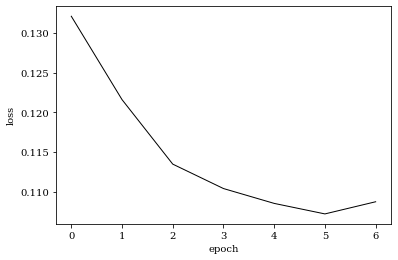

test_loss: 0.105, test_acc: 0.974


In [6]:

'''
4. モデルの評価
'''
val_loss=hist['val_loss']

fig=plt.figure()
plt.rc('font',family='serif')
plt.plot(range(len(val_loss)),val_loss,color='black',linewidth=1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

test_loss=metrics.Mean()
test_acc=metrics.SparseCategoricalAccuracy()

def test_step(x,t):
    preds=model(x)
    loss=compute_loss(t,preds)
    test_loss(loss)
    test_acc(t,preds)
    return loss

test_step(x_test,t_test)

print('test_loss: {:.3}, test_acc: {:.3f}'.format(test_loss.result(),test_acc.result()))